[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/regression/regularization.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Regularization

Regularization is an important technique used to prevent overfitting in machine learning models. This notebook shows different regularization approaches to reduce overfitting.

We use a modification and curated version of the [Housing Prices Dataset](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset) stored in `data/housing_curated.csv`.

In [73]:
# make sure the required packages are installed
%pip install numpy pandas scikit-learn matplotlib seaborn --quiet

repo='data-science-course'
module='regression'
# if running in colab, install the required packages and copy the necessary files
if get_ipython().__class__.__module__.startswith('google.colab'):
    import os
    if not os.path.exists(repo):
        !git clone --filter=blob:none --sparse https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
        !cd {repo} && git sparse-checkout init --cone && git sparse-checkout set {module}  2>/dev/null
    !cp --update {repo}/{module}/*.py . 2>/dev/null
    !mkdir -p img data
    !mv {repo}/{module}/img/* img/.  2>/dev/null
    !mv {repo}/{module}/data/* data/.  2>/dev/null

# import the required modules
from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler
import pandas as pd

import utils

pd.set_option('display.max_columns', None)  # Display all columns of a DataFrame in pandas
random_state = 41

Note: you may need to restart the kernel to use updated packages.


## Dataset

Dataset meta information:

In [74]:
dataset_file_name = 'data/housing_curated.csv'
integer_independent_vars = ['bedrooms', 'bathrooms', 'stories', 'parking', 'width', 'length', 'quality']
binary_independent_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea',
            'furnishingstatus_furnished','furnishingstatus_semi-furnished','furnishingstatus_unfurnished']
independent_vars = integer_independent_vars + binary_independent_vars
dependent_var = 'price'

### Load the dataset

Load the dataset and break it into training and testing sets.

In [75]:
# Split the dataset into training and testing sets
(X_train, y_train), (X_test, y_test) = utils.load_dataset_from_csv(dataset_file_name, independent_vars,
                                                                   dependent_var, 0.2, random_state)
#utils.impute_mean(X_train, 'quality')  # impute missing values in 'quality' with the mean
#utils.impute_mean(X_test, 'quality')   # impute missing values in 'quality
print(f"Training set shape: {X_train.shape}.")
print("Training set description:\n", X_train.describe(), end='\n\n')

Training set shape: (440, 16).
Training set description:
          bedrooms   bathrooms     stories     parking      width      length  \
count  440.000000  440.000000  440.000000  440.000000  440.00000  440.000000   
mean     2.954437    1.277273    1.801737    0.686364   49.20000  119.590909   
std      0.716052    0.487130    0.871936    0.849384   12.36263   26.017707   
min      1.000000    1.000000    1.000000    0.000000   29.00000   70.000000   
25%      2.714123    1.000000    1.000000    0.000000   41.00000  102.000000   
50%      3.000000    1.000000    2.000000    0.000000   48.00000  116.000000   
75%      3.000000    2.000000    2.000000    1.000000   55.00000  135.000000   
max      6.000000    3.000000    4.000000    3.000000  183.00000  310.000000   

           quality    mainroad   guestroom    basement  hotwaterheating  \
count   440.000000  440.000000  440.000000  440.000000       440.000000   
mean   2164.725909    0.875000    0.177273    0.343182         0.052273

### Scale the dataset

Scale the dataset using the `RobustScaler` which is more robust to outliers.

In [76]:
# Scale the dataset
X_train_scaled, X_test_scaled = utils.scale_X_dataset(RobustScaler(), X_train, X_test)
# show the number of features
print(f"Training set shape: {X_train_scaled.shape}.")
print("Training set description:\n",
      pd.DataFrame(X_train_scaled, columns=X_train.columns).describe(),  # convert X_train_scaled from ndarray to DataFrame for better visualization
      end='\n\n')

Training set shape: (440, 16).
Training set description:
          bedrooms   bathrooms     stories     parking       width      length  \
count  440.000000  440.000000  440.000000  440.000000  440.000000  440.000000   
mean    -0.159381    0.277273   -0.198263    0.686364    0.085714    0.108815   
std      2.504757    0.487130    0.871936    0.849384    0.883045    0.788415   
min     -6.996016    0.000000   -1.000000    0.000000   -1.357143   -1.393939   
25%     -1.000000    0.000000   -1.000000    0.000000   -0.500000   -0.424242   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    1.000000    0.000000    1.000000    0.500000    0.575758   
max     10.494024    2.000000    2.000000    3.000000    9.642857    5.878788   

          quality    mainroad   guestroom    basement  hotwaterheating  \
count  440.000000  440.000000  440.000000  440.000000       440.000000   
mean     0.031200   -0.125000    0.177273    0.343182         0.

## Linear Regression Model

Train a linear regression model on the dataset and evaluate its performance.

Model performance with the original features:


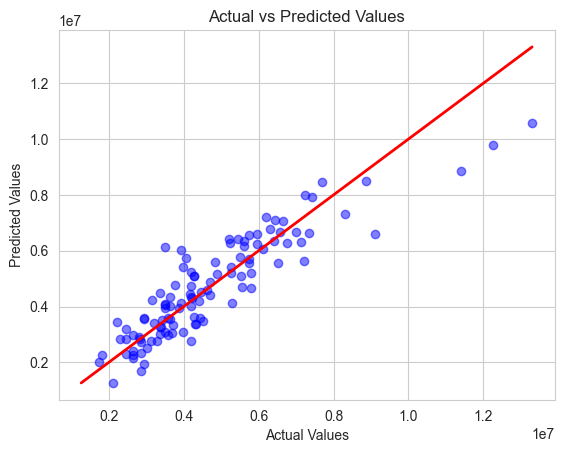

Mean Squared Error (MSE): 782943544394.9401
Root Mean Squared Error (RMSE): 884840.9712
Mean Absolute Error (MAE): 666143.5804
R-squared determination coefficient: 0.8094



In [77]:
print("Model performance with the original features:")
utils.show_regression_performance(
    *utils.create_SDG_regression_model_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, random_state))

## Polynomial Regression Model

We now create a polynomial regression model, scale the new features, fit it to the dataset, and evaluate its performance.

Training set shape: (440, 968).
Model performance after adding the polynomial features:


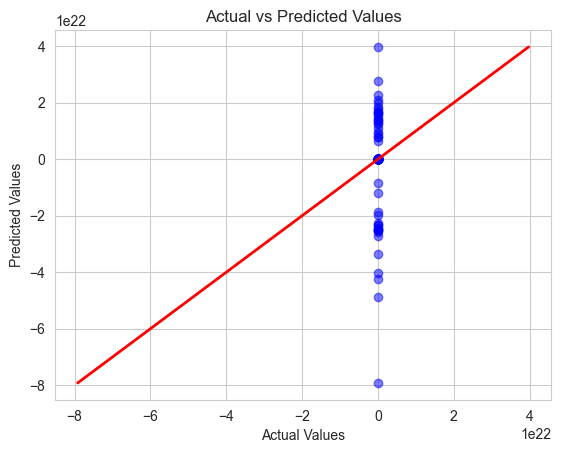

Mean Squared Error (MSE): 247726917904209640576506401654114518072033280.0000
Root Mean Squared Error (RMSE): 15739342994680865357824.0000
Mean Absolute Error (MAE): 8327905889066991747072.0000
R-squared determination coefficient: -60313929911944910482143923142656.0000



In [78]:
# Create the polynomial features with degree of 3
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
# show the number of features
print(f"Training set shape: {X_train_poly.shape}.")
# Scale the dataset
X_train_scaled, X_test_scaled = utils.scale_X_dataset(RobustScaler(), X_train_poly, X_test_poly)
# evaluate the model
print("Model performance after adding the polynomial features:")
utils.show_regression_performance(
    *utils.create_SDG_regression_model_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, random_state))

## ✨ Questions ✨

1. Does the model's performance improve after adding polynomial features?
2. Why?
3. How can we reduce overfitting?

### Answers

*Write your answers here.*


## Feature Selection

Let's select the best features using the `SelectKBest` method and evaluate the model's performance. `SelectKBest` selects the top $k$ features based on a parameterizable score. 

Model performance after adding the polynomial features and selecting the best 16 features:


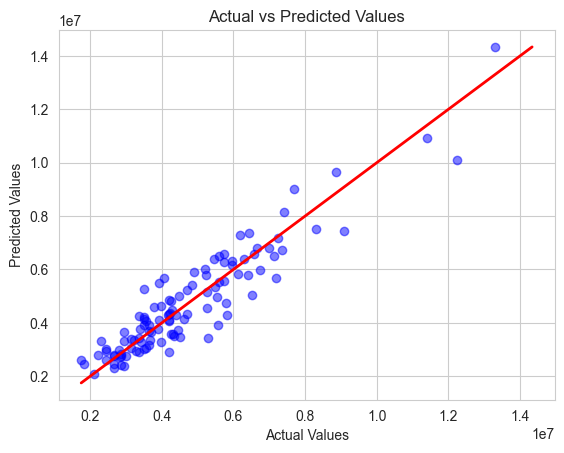

Mean Squared Error (MSE): 554034450097.8608
Root Mean Squared Error (RMSE): 744334.9045
Mean Absolute Error (MAE): 579749.4137
R-squared determination coefficient: 0.8651



In [79]:
# we want as many features as the original independent vars
features_to_select = len(independent_vars)
selector = SelectKBest(score_func=f_regression,  # univariate ANOVA F-test for linear relationship with the target
                       k=features_to_select)  # select same number as the original independent vars
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)
# evaluate the model
print(f"Model performance after adding the polynomial features and selecting the best {features_to_select} features:")
utils.show_regression_performance(
    *utils.create_SDG_regression_model_and_evaluate(X_train_selected, y_train, X_test_selected, y_test, random_state))

## ✨ Questions ✨

4. Does the model's performance improve after selecting the best features? Why?
5. Is the performance better than the original linear model? Why?
6. What would you think it would happen if we halve the number of selected features? Do it!

### Answers

*Write your answers here.*


In [80]:
# Write your code here



## ✨ Questions ✨

7. How do you think we could find the optimal number of features to select?

### Answers

*Write your answers here.*


## L1 (Lasso) Regularization

Let's apply L1 regularization to polynomial features with all the features (we will use the `SGDRegressor` model with L1 regularization). We first select too many features on purpose to see the effect of L1 regularization.

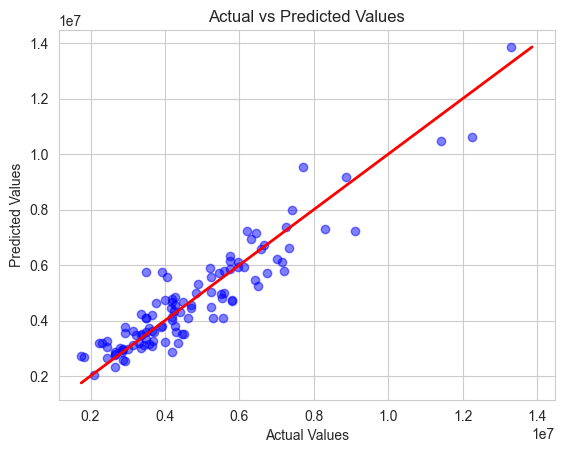

Model performance after adding the polynomial features and L1 regularization:
Mean Squared Error (MSE): 544325412840.1209
Root Mean Squared Error (RMSE): 737784.1235
Mean Absolute Error (MAE): 565869.7673
R-squared determination coefficient: 0.8675
Out of 80 to select, L1 (alpha=5000.0) has reduced them to 54.



In [81]:
# We first select lots of features on purpose to see the effect of L1 regularization
features_to_select = 5*len(independent_vars)  # Select 5 times the original independent vars
alpha = 5e3 # regularization parameter, a.k.a. lambda, to be found with hyperparameter tuning
selector = SelectKBest(score_func=f_regression, k=features_to_select)  
X_train_many_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_many_selected = selector.transform(X_test_scaled)
model = SGDRegressor(penalty='l1', alpha=alpha, random_state=random_state)
model.fit(X_train_many_selected, y_train)
y_pred = model.predict(X_test_many_selected)
utils.plot_actual_vs_predicted_values(y_test, y_pred)
# Model evaluation
print(f"Model performance after adding the polynomial features and L1 regularization:")
metrics = utils.evaluate_regression(y_test, y_pred)
utils.show_regression_performance(*metrics, end='\n')
# print the number of features that have been reduced (the rest have been set to zero)
print(f"Out of {features_to_select} to select, L1 (alpha={alpha}) has reduced them to {len(model.coef_.nonzero()[0])}.\n")

## ✨ Questions ✨

8. What is the effect of L1 regularization?
9. What happens if we increase the alpha (a.k.a. $\lambda$) parameter (let's say to 1e50)? Try it!
10. What happens if we decrease the alpha (a.k.a. $\lambda$) parameter (let's say to 1e-5)? Try it!

### Answers

*Write your answers here.*


## L2 (Ridge) + L1 (Lasso) Regularization = Elastic Net

By default, `SGDRegressor` uses L2 regularization. L2 regularization prevents coefficients from becoming too large, but it does not commonly reduce them to zero. Elastic Net combines L1 and L2 regularization. Thus, it can reduce the number of features and prevent coefficients from becoming too large.

Let's apply Elastic Net to the polynomial features with all the features 

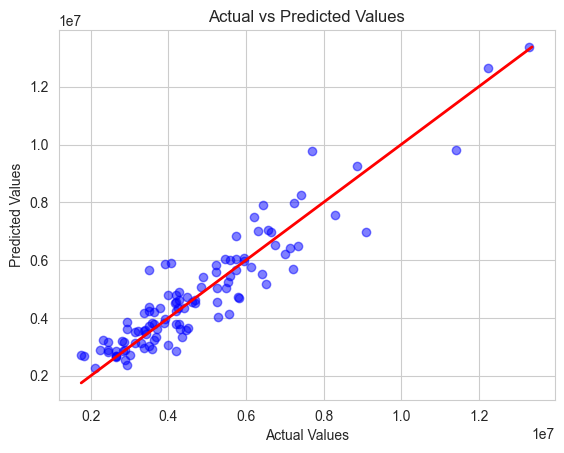

Model performance after adding the polynomial features and L1+L2 regularization:
Mean Squared Error (MSE): 585489954418.0255
Root Mean Squared Error (RMSE): 765173.1532
Mean Absolute Error (MAE): 582856.1318
R-squared determination coefficient: 0.8575
Out of 48 to select, L1+L2 (alpha=1) has reduced them to 48.



In [82]:
features_to_select = 3*len(independent_vars)  # Select 3 times the original independent vars
alpha = 1  # regularization parameter, a.k.a. lambda, to be found with hyperparameter tuning
selector = SelectKBest(score_func=f_regression, k=features_to_select)  
X_train_many_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_many_selected = selector.transform(X_test_scaled)
model = SGDRegressor(penalty='elasticnet',  # Elastic Net
                     alpha=alpha, l1_ratio=0.5, # L1 ratio of 0.5, l2_ratio of 0.5
                     random_state=random_state)  
model.fit(X_train_many_selected, y_train)
y_pred = model.predict(X_test_many_selected)
utils.plot_actual_vs_predicted_values(y_test, y_pred)
# Model evaluation
print(f"Model performance after adding the polynomial features and L1+L2 regularization:")
metrics = utils.evaluate_regression(y_test, y_pred)
utils.show_regression_performance(*metrics, end='\n')
print(f"Out of {features_to_select} to select, L1+L2 (alpha={alpha}) has reduced "
      f"them to {len(model.coef_.nonzero()[0])}.\n")

## ✨ Questions ✨

11. Has the L1+L2 regularization improved the model's performance? Why?

### Answers

*Write your answers here.*